##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Eager execution


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/eager"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/eager.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/eager.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/eager.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

TensorFlow's eager execution is an imperative programming environment that
evaluates operations immediately, without building graphs: operations return
concrete values instead of constructing a computational graph to run later. This
makes it easy to get started with TensorFlow and debug models, and it
reduces boilerplate as well. To follow along with this guide, run the code
samples below in an interactive `python` interpreter.

Eager execution is a flexible machine learning platform for research and
experimentation, providing:

* *An intuitive interface*—Structure your code naturally and use Python data
  structures. Quickly iterate on small models and small data.
* *Easier debugging*—Call ops directly to inspect running models and test
  changes. Use standard Python debugging tools for immediate error reporting.
* *Natural control flow*—Use Python control flow instead of graph control
  flow, simplifying the specification of dynamic models.

Eager execution supports most TensorFlow operations and GPU acceleration.

Note: Some models may experience increased overhead with eager execution
enabled. Performance improvements are ongoing, but please
[file a bug](https://github.com/tensorflow/tensorflow/issues) if you find a
problem and share your benchmarks.

## Setup and basic usage

In [2]:
import os

import tensorflow as tf

import cProfile

In Tensorflow 2.0, eager execution is enabled by default.

In [3]:
tf.executing_eagerly()

True

Now you can run TensorFlow operations and the results will return immediately:

In [4]:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

hello, [[4.]]


Enabling eager execution changes how TensorFlow operations behave—now they
immediately evaluate and return their values to Python. `tf.Tensor` objects
reference concrete values instead of symbolic handles to nodes in a computational
graph. Since there isn't a computational graph to build and run later in a
session, it's easy to inspect results using `print()` or a debugger. Evaluating,
printing, and checking tensor values does not break the flow for computing
gradients.

Eager execution works nicely with [NumPy](http://www.numpy.org/). NumPy
operations accept `tf.Tensor` arguments. The TensorFlow
`tf.math` operations convert
Python objects and NumPy arrays to `tf.Tensor` objects. The
`tf.Tensor.numpy` method returns the object's value as a NumPy `ndarray`.

In [5]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [6]:
# Broadcasting support
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [7]:
# Operator overloading is supported
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [8]:
# Use NumPy values
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [9]:
# Obtain numpy value from a tensor:
print(a.numpy())
# => [[1 2]
#     [3 4]]

[[1 2]
 [3 4]]


## Dynamic control flow

A major benefit of eager execution is that all the functionality of the host
language is available while your model is executing. So, for example,
it is easy to write [fizzbuzz](https://en.wikipedia.org/wiki/Fizz_buzz):

In [10]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [11]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


This has conditionals that depend on tensor values and it prints these values
at runtime.

## Eager training

### Computing gradients

[Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)
is useful for implementing machine learning algorithms such as
[backpropagation](https://en.wikipedia.org/wiki/Backpropagation) for training
neural networks. During eager execution, use `tf.GradientTape` to trace
operations for computing gradients later.

You can use `tf.GradientTape` to train and/or compute gradients in eager. It is especially useful for complicated training loops.  

Since different operations can occur during each call, all
forward-pass operations get recorded to a "tape". To compute the gradient, play
the tape backwards and then discard. A particular `tf.GradientTape` can only
compute one gradient; subsequent calls throw a runtime error.

In [12]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad)  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


### Train a model

The following example creates a multi-layer model that classifies the standard
MNIST handwritten digits. It demonstrates the optimizer and layer APIs to build
trainable graphs in an eager execution environment.

In [13]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [14]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

Even without training, call the model and inspect the output in eager execution:

In [15]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[-0.01775933 -0.01194787 -0.08372174 -0.06535977  0.00338565 -0.01974326
  -0.04763228  0.00904049 -0.00144051 -0.01944664]]


While keras models have a builtin training loop (using the `fit` method), sometimes you need more customization. Here's an example, of a training loop implemented with eager:

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

Note: Use the assert functions in `tf.debugging` to check if a condition holds up. This works in eager and graph execution.

In [17]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)
    
    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))
    
    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [18]:
def train(epochs):
  for epoch in range(epochs):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

In [19]:
train(epochs = 3)

Epoch 0 finished


Epoch 1 finished


Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

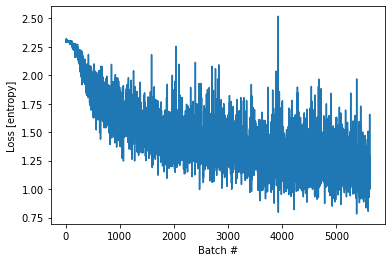

In [20]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

### Variables and optimizers

`tf.Variable` objects store mutable `tf.Tensor`-like values accessed during
training to make automatic differentiation easier. 

The collections of variables can be encapsulated into layers or models, along with methods that operate on them. See [Custom Keras layers and models](./keras/custom_layers_and_models.ipynb) for details. The main difference between layers and models is that models add methods like  `Model.fit`, `Model.evaluate`, and `Model.save`.

For example, the automatic differentiation example above
can be rewritten:

In [21]:
class Linear(tf.keras.Model):
  def __init__(self):
    super(Linear, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

In [22]:
# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

Next:

1. Create the model.
2. The Derivatives of a loss function with respect to model parameters.
3. A strategy for updating the variables based on the derivatives.

In [23]:
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

steps = 300
for i in range(steps):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

Initial loss: 69.909
Loss at step 000: 67.145
Loss at step 020: 30.170


Loss at step 040: 13.859
Loss at step 060: 6.659
Loss at step 080: 3.479
Loss at step 100: 2.074
Loss at step 120: 1.453


Loss at step 140: 1.178
Loss at step 160: 1.056
Loss at step 180: 1.003
Loss at step 200: 0.979
Loss at step 220: 0.968


Loss at step 240: 0.963
Loss at step 260: 0.961
Loss at step 280: 0.960


In [24]:
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Final loss: 0.960


In [25]:
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

W = 2.9515867233276367, B = 2.0210201740264893


Note: Variables persist until the last reference to the python object
is removed, and is the variable is deleted.

### Object-based saving


A `tf.keras.Model` includes a convenient `save_weights` method allowing you to easily create a checkpoint: 

In [26]:
model.save_weights('weights')
status = model.load_weights('weights')

Using `tf.train.Checkpoint` you can take full control over this process.

This section is an abbreviated version of the [guide to training checkpoints](./checkpoint.ipynb).


In [27]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [28]:
x.assign(2.)   # Assign a new value to the variables and save.
checkpoint_path = './ckpt/'
checkpoint.save(checkpoint_path)

'./ckpt/-1'

In [29]:
x.assign(11.)  # Change the variable after saving.

# Restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


To save and load models, `tf.train.Checkpoint` stores the internal state of objects,
without requiring hidden variables. To record the state of a `model`,
an `optimizer`, and a global step, pass them to a `tf.train.Checkpoint`:

In [30]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

Note: In many training loops, variables are created after `tf.train.Checkpoint.restore` is called. These variables will be restored as soon as they are created, and assertions are available to ensure that a checkpoint has been fully loaded. See the [guide to training checkpoints](./checkpoint.ipynb) for details.

### Object-oriented metrics

`tf.keras.metrics` are stored as objects. Update a metric by passing the new data to
the callable, and retrieve the result using the `tf.keras.metrics.result` method,
for example:

In [31]:
m = tf.keras.metrics.Mean("loss")
m(0)
m(5)
m.result()  # => 2.5
m([8, 9])
m.result()  # => 5.5

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

### Summaries and TensorBoard

[TensorBoard](https://tensorflow.org/tensorboard) is a visualization tool for
understanding, debugging and optimizing the model training process. It uses
summary events that are written while executing the program.

You can use `tf.summary` to record summaries of variable in eager execution.
For example, to record summaries of `loss` once every 100 training steps:

In [32]:
logdir = "./tb/"
writer = tf.summary.create_file_writer(logdir)

steps = 1000
with writer.as_default():  # or call writer.set_as_default() before the loop.
  for i in range(steps):
    step = i + 1
    # Calculate loss with your real train function.
    loss = 1 - 0.001 * step
    if step % 100 == 0:
      tf.summary.scalar('loss', loss, step=step)

In [33]:
!ls tb/

events.out.tfevents.1632342765.kokoro-gcp-ubuntu-prod-230753280.22287.0.v2


## Advanced automatic differentiation topics

### Dynamic models

`tf.GradientTape` can also be used in dynamic models. This example for a
[backtracking line search](https://wikipedia.org/wiki/Backtracking_line_search)
algorithm looks like normal NumPy code, except there are gradients and is
differentiable, despite the complex control flow:

In [34]:
def line_search_step(fn, init_x, rate=1.0):
  with tf.GradientTape() as tape:
    # Variables are automatically tracked.
    # But to calculate a gradient from a tensor, you must `watch` it.
    tape.watch(init_x)
    value = fn(init_x)
  grad = tape.gradient(value, init_x)
  grad_norm = tf.reduce_sum(grad * grad)
  init_value = value
  while value > init_value - rate * grad_norm:
    x = init_x - rate * grad
    value = fn(x)
    rate /= 2.0
  return x, value

### Custom gradients

Custom gradients are an easy way to override gradients. Within the forward function, define the gradient with respect to the
inputs, outputs, or intermediate results. For example, here's an easy way to clip
the norm of the gradients in the backward pass:

In [35]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
  y = tf.identity(x)
  def grad_fn(dresult):
    return [tf.clip_by_norm(dresult, norm), None]
  return y, grad_fn

Custom gradients are commonly used to provide a numerically stable gradient for a
sequence of operations:

In [36]:
def log1pexp(x):
  return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)


In [37]:
# The gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [38]:
# However, x = 100 fails because of numerical instability.
grad_log1pexp(tf.constant(100.)).numpy()

nan

Here, the `log1pexp` function can be analytically simplified with a custom
gradient. The implementation below reuses the value for `tf.exp(x)` that is
computed during the forward pass—making it more efficient by eliminating
redundant calculations:

In [39]:
@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)


In [40]:
# As before, the gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [41]:
# And the gradient computation also works at x = 100.
grad_log1pexp(tf.constant(100.)).numpy()

1.0

## Performance

Computation is automatically offloaded to GPUs during eager execution. If you
want control over where a computation runs you can enclose it in a
`tf.device('/gpu:0')` block (or the CPU equivalent):

In [42]:
import time

def measure(x, steps):
  # TensorFlow initializes a GPU the first time it's used, exclude from timing.
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  # tf.matmul can return before completing the matrix multiplication
  # (e.g., can return after enqueing the operation on a CUDA stream).
  # The x.numpy() call below will ensure that all enqueued operations
  # have completed (and will also copy the result to host memory,
  # so we're including a little more than just the matmul operation
  # time).
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
  print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# Run on GPU, if available:
if tf.config.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
  print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:


CPU: 1.007401466369629 secs
GPU: 0.04124784469604492 secs


A `tf.Tensor` object can be copied to a different device to execute its
operations:

In [43]:
if tf.config.list_physical_devices("GPU"):
  x = tf.random.normal([10, 10])

  x_gpu0 = x.gpu()
  x_cpu = x.cpu()

  _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
  _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0

Instructions for updating:
Use tf.identity instead.


Instructions for updating:
Use tf.identity instead.


### Benchmarks

For compute-heavy models, such as
[ResNet50](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/python/eager/benchmarks/resnet50)
training on a GPU, eager execution performance is comparable to `tf.function` execution.
But this gap grows larger for models with less computation and there is work to
be done for optimizing hot code paths for models with lots of small operations.

## Work with functions

While eager execution makes development and debugging more interactive,
TensorFlow 1.x style graph execution has advantages for distributed training, performance
optimizations, and production deployment. To bridge this gap, TensorFlow 2.0 introduces `function`s via the `tf.function` API. For more information, see the [tf.function](./function.ipynb) guide.